In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import json
import matplotlib.dates as mdates
import seaborn as sns
import psycopg2
cm = sns.light_palette("green", as_cmap=True)

import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [2]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')
campaign = pd.read_csv('~/Documents/appreciate/campaigns.csv')
campaign

ssb_campaign_uuid                                     name
0    06999d835967801342ac5e0138b30d6b            DT_DailyThemedCrossword_US_T1
1    c340be500e580ccc4452bcb470da4949             Playsimple-Word Trip-US-RTGT
2    cfbad4e5cdfcf8e68d0ff1ddb5135586     SingleTap_FB_ROW_Android_Video_FB_US
3    2359e9439151f256228cedd5f8780ed4   SingleTap_FB_ROW_Android_Display_FB_US
4    0c0ded719c3afb709b937d7a19e98991     Position Mobile - NewsHome - US - UA
..                                ...                                      ...
193  43242a117923679a04b02c58f671f1a8     SingleTap_FB_ROW_Android_Video_FB_MX
194  5c2cc36dc709f65250ad09e9926f2020   SmartNews_Cricket_SingleTap_All_CPI_V2
195  dad68c13e535c25d96b8a8af78f04033  SmartNews_Tracfone_SingleTap_All_CPI_V2
196  d71c42106c0bce1ab4ec672121dfe9a6             Stars Group-Poker Stars-BR-2
197  b8ccac17c71b8482cc92647a94577a57            Tiktok - TiktTok - MX - PR RT

[198 rows x 2 columns]

In [34]:
start_dt = '2021-05-13'
end_dt = '2021-05-19'


In [138]:
impressions = bigquery_client.query(f"""
SELECT 
    r.ssb_campaign_uuid
    , p.bundle
    , case when r.ssb_buyer_id = 3549 then 'DT' else 'other' end as buyer
    , sum(revenue) revenue
    , count(case when event_type = 'clear' then r.tid else NULL end)*16 as impressions
    , count(case when event_type = 'clear' then aud.tid else NULL end)*16 as audience_impressions
    , count(distinct case when event_type = 'clear' then r.tid else NULL end)*16 as users
    , count(distinct case when event_type = 'clear' then aud.tid else NULL end)*16 as audience_users
FROM `apprec-prod.stats.rows` r
left join (
    select 
        distinct(tid) 
    from `apprec-prod.audiences.dt_aud` 
) aud
    on r.tid = aud.tid
left join metadata.apps p
    on r.sponsored_app_id = p.app_id
WHERE date >= "{start_dt}" and date<="{end_dt}"
and left(id,1) = '0'
group by 1,2,3
order by users desc
""").to_dataframe()
impressions

ssb_campaign_uuid                  bundle  buyer  \
0    16dd6a2d270567b7135d8b38c8ea5c14        com.mercadolibre  other   
1    90ea0b95f5b866a4c7d6c5de1d0e195d  com.mercadopago.wallet  other   
2    8f6af55d3b890df1566e59c4bcf13d3c               284035177     DT   
3    24ef16e4c85df34d2d721262a28a6e4a               359917414  other   
4    a1dd9f2ab72d27d0e3cc234fefd3b03e     com.twitter.android     DT   
..                                ...                     ...    ...   
649  d4c8a52922f11f6e61a8150702f65c7b                    None  other   
650  036c1074ba6de1eba6e7292bd28dae56                    None  other   
651  4a45b896b92e0c69a692f3c0c97d5bc0                    None  other   
652                              None                    None  other   
653  eaa8b14fee8f855a7d42a412984f9798                    None  other   

        revenue  impressions  audience_impressions     users  audience_users  
0     218.45000     26571840               6684304  10187776         2454608  
1     192.80000     22067584               4290192   9211504         1629888  
2    1292.00000     23045920                    16   8159440              16  
3     990.00000     21914800                     0   6211536               0  
4     308.80000     16633056               2333680   6156560          809184  
..          ...          ...                   ...       ...             ...  
649     0.00000           48                     0        16               0  
650     0.00000           16                     0        16               0  
651     0.00414           16                     0        16               0  
652         NaN            0                     0         0               0  
653     0.01764            0                     0         0               0  

[654 rows x 8 columns]

In [139]:
impressions['imp_overlap'] = round(impressions['audience_impressions']/impressions['impressions'],4)
impressions['user_overlap'] = round(impressions['audience_users']/impressions['users'],4)
impressions['advertiser_revenue'] = impressions.groupby('bundle')['revenue'].transform('sum')
impressions['sov_of_adv'] = impressions['revenue']/impressions['advertiser_revenue']
impressions = impressions[['ssb_campaign_uuid', 'bundle', 'buyer', 'revenue', 'advertiser_revenue',
       'impressions', 'audience_impressions', 'users', 'audience_users',
       'imp_overlap', 'user_overlap']]
impressions

ssb_campaign_uuid                  bundle  buyer  \
0    16dd6a2d270567b7135d8b38c8ea5c14        com.mercadolibre  other   
1    90ea0b95f5b866a4c7d6c5de1d0e195d  com.mercadopago.wallet  other   
2    8f6af55d3b890df1566e59c4bcf13d3c               284035177     DT   
3    24ef16e4c85df34d2d721262a28a6e4a               359917414  other   
4    a1dd9f2ab72d27d0e3cc234fefd3b03e     com.twitter.android     DT   
..                                ...                     ...    ...   
649  d4c8a52922f11f6e61a8150702f65c7b                    None  other   
650  036c1074ba6de1eba6e7292bd28dae56                    None  other   
651  4a45b896b92e0c69a692f3c0c97d5bc0                    None  other   
652                              None                    None  other   
653  eaa8b14fee8f855a7d42a412984f9798                    None  other   

        revenue  advertiser_revenue  impressions  audience_impressions  \
0     218.45000              359.85     26571840               6684304   
1     192.80000              345.80     22067584               4290192   
2    1292.00000             1292.00     23045920                    16   
3     990.00000             1295.50     21914800                     0   
4     308.80000             5913.85     16633056               2333680   
..          ...                 ...          ...                   ...   
649     0.00000                 NaN           48                     0   
650     0.00000                 NaN           16                     0   
651     0.00414                 NaN           16                     0   
652         NaN                 NaN            0                     0   
653     0.01764                 NaN            0                     0   

        users  audience_users  imp_overlap  user_overlap  
0    10187776         2454608       0.2516        0.2409  
1     9211504         1629888       0.1944        0.1769  
2     8159440              16       0.0000        0.0000  
3     6211536               0       0.0000        0.0000  
4     6156560          809184       0.1403        0.1314  
..        ...             ...          ...           ...  
649        16               0       0.0000        0.0000  
650        16               0       0.0000        0.0000  
651        16               0       0.0000        0.0000  
652         0               0          NaN           NaN  
653         0               0          NaN           NaN  

[654 rows x 11 columns]

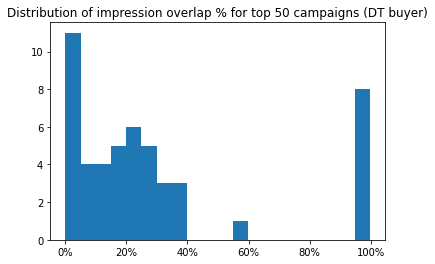

In [140]:

plt.hist(impressions[impressions.buyer == 'DT'].loc[:,'imp_overlap'].head(50), bins = 20)
plt.title('Distribution of impression overlap % for top 50 campaigns (DT buyer)')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

In [16]:
impressions = impressions.set_index('ssb_campaign_uuid').join(campaign.set_index('ssb_campaign_uuid'), how = 'left').reset_index()
impressions['name'] = impressions['name'].fillna(0)

exp_1 = [' rt','-rt',' pr','-pr',' retar','-retar','-1','- 1']
exp_2 = [' ua','-ua','-2','- 2']
exp_3 = [' gp','-gp','-3','- 3']
exp_4 = ['true gp','true-gp','true_gp','-4','- 4']

def classify_campaigns(r):
    if any(substr in str(r['name']).lower() for substr in exp_1):
        return 1
    elif any(substr in str(r['name']).lower() for substr in exp_4):
        return 4
    elif any(substr in str(r['name']).lower() for substr in exp_3):
        return 3
    elif any(substr in str(r['name']).lower() for substr in exp_2):
        return 2
    else:
        return -1
    
impressions['campaign_type'] = impressions.apply(lambda x:classify_campaigns(x), axis = 1)

In [142]:
impressions.sort_values(['advertiser_revenue','revenue'], ascending = False, inplace = True)
impressions.to_csv(f'~/Downloads/Appreciate_audience_overlap_{start_dt}_{end_dt}.csv', index = False)
impressions.head(50)

ssb_campaign_uuid                      bundle  buyer  \
48   c5534bbfcb4dccdd122f22da877a6f78  com.particlenews.newsbreak     DT   
170  60afc4f294695ffe7ea525534f019d20  com.particlenews.newsbreak     DT   
6    16d935fca4ea8b4dffa296ba147ec7df  com.particlenews.newsbreak     DT   
208  b291b1c34d27bb722c2a3cd95748e5f0  com.particlenews.newsbreak     DT   
114  5d294c23d51b0c64a63275f4b8412067  com.particlenews.newsbreak     DT   
209  50a1b5ac38354aa6f2b023e8e462c883  com.particlenews.newsbreak     DT   
255  e667256b49c75577c5632ec85ab6a16a  com.particlenews.newsbreak     DT   
371  8e6627e38eabb03d429be94f92c185f5  com.particlenews.newsbreak     DT   
194  d3a92d5cb2d98df0faf1fe0c47478e21  com.particlenews.newsbreak     DT   
296  c40b9831f92edcadd201041150f92c5e  com.particlenews.newsbreak     DT   
218  fe64a9f1d0e4986d64879d60781f14cf  com.particlenews.newsbreak     DT   
461  f0bd53b3e0ea49b47df690e225132b07  com.particlenews.newsbreak     DT   
120  95f82f59fd9cac3b272b560f722e35d6  com.particlenews.newsbreak     DT   
199  33bff90d655b976e9399f1d0b0463d22  jp.gocro.smartnews.android     DT   
207  5fef83d15c5b811b424ed58aeb82d0a7  jp.gocro.smartnews.android     DT   
226  eb6dbe92b98fe9a91b00eb06ae37070e  jp.gocro.smartnews.android     DT   
248  d8be47c87ebd5047c552f92421103f1a  jp.gocro.smartnews.android     DT   
117  460c77fda3ba6cdf651311f5eedb7187  jp.gocro.smartnews.android     DT   
356  dad68c13e535c25d96b8a8af78f04033  jp.gocro.smartnews.android     DT   
13   52e074885806d19e5393c010eca2617d  jp.gocro.smartnews.android     DT   
86   099a5d47e9bf3796c1b9ca5c5f4bc264  jp.gocro.smartnews.android     DT   
10   30968a4138fff2fb0b0601173f9d39e2  jp.gocro.smartnews.android     DT   
344  608ffd6123bdbf7eef34f27889501862  jp.gocro.smartnews.android     DT   
385  5c2cc36dc709f65250ad09e9926f2020  jp.gocro.smartnews.android     DT   
20   626100a0509365a389a45a8d8e696ac1  jp.gocro.smartnews.android     DT   
201  0845c2b2f652fe4e4a959d7edd27de2a  jp.gocro.smartnews.android     DT   
188  4850bb10d192985514ba8b61023f0ac0   com.moonactive.coinmaster  other   
524  665cfc6226f41068aa4b90652bde1862   com.moonactive.coinmaster  other   
35   ebd6e39117bfd485b3b15243f3e07bad         com.twitter.android     DT   
38   292906bbb71deaebb880439ce8c72995         com.twitter.android     DT   
42   949d2cb0616d95548bf7a4010a611373         com.twitter.android     DT   
4    a1dd9f2ab72d27d0e3cc234fefd3b03e         com.twitter.android     DT   
21   c3fd3bd696b73e7c4aa683c5457e4ab2         com.twitter.android     DT   
169  058d1b7ac105ca32cc5fe34b2cf3abb8         com.twitter.android     DT   
19   c6583d198719c3adb7a5648ed72ce27a         com.twitter.android     DT   
8    5e3c12bd35bb9872d01487e8951075ee         com.twitter.android     DT   
15   b7c89cdb901658c9b5cde8b89203d0f0         com.twitter.android     DT   
44   239c775280e160411963f7001380dd70         com.twitter.android     DT   
126  ea2d065f257f94110950e319a5ceeccf         com.twitter.android     DT   
57   1aa6cc192b06ff5f9c92ad156b22988b         com.twitter.android     DT   
177  fc2ba0e560c59f4ee98f9e8b6f7d89d4         com.twitter.android     DT   
24   9fdff34a50df11585893a41ac9e6a30d         com.twitter.android     DT   
37   ec32166fa4eda27c5235e71e5765e7a1         com.twitter.android     DT   
80   152d83ad85c3eb9a14c5c21aea6e7d84         com.twitter.android     DT   
203  b5100ac9db3b4065435f41827807fae6         com.twitter.android     DT   
89   741b622cf9f7b2e747451ae925d01e9c         com.twitter.android     DT   
84   b4e0996eefc5a1c33552ead9f4fa46f3         com.twitter.android     DT   
61   65b37ef0810672f4f347d5326d26bb32         com.twitter.android     DT   
77   154b40ab5f22454cefd235bcd7f4bb10         com.twitter.android     DT   
204  052f98115f3f0c873bebe40fd3368e74         com.twitter.android     DT   

      revenue  advertiser_revenue  impressions  audience_impressions    users  \
48   11217.00            24391.35      6025376               5

(array([ 1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1., 48.]),
 array([0.2091  , 0.248645, 0.28819 , 0.327735, 0.36728 , 0.406825,
        0.44637 , 0.485915, 0.52546 , 0.565005, 0.60455 , 0.644095,
        0.68364 , 0.723185, 0.76273 , 0.802275, 0.84182 , 0.881365,
        0.92091 , 0.960455, 1.      ]),
 <BarContainer object of 20 artists>)

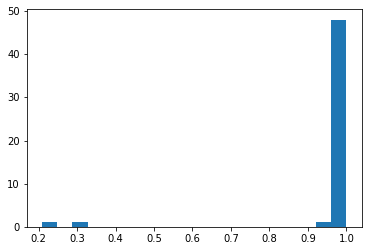

In [143]:
plt.hist(impressions.loc[(impressions.buyer == 'DT') & (impressions.campaign_type == 2), 'imp_overlap'], bins = 20)


In [100]:
us_impressions = bigquery_client.query(f"""
SELECT 
    r.ssb_campaign_uuid
    , case when r.ssb_buyer_id = 3549 then 'DT' else 'other' end as buyer
    , count(r.tid)*16 as impressions
    , count(aud.tid)*16 as audience_impressions
    , count(distinct r.tid)*16 as users
    , count(distinct aud.tid)*16 as audience_users
FROM `apprec-prod.stats.rows` r
left join (
    select 
        distinct(tid) 
    from `apprec-prod.audiences.dt_aud` 
    where country = 'US'
) aud
    on r.tid = aud.tid
WHERE date >= "{start_dt}" and date<="{end_dt}"
and event_type='clear'
and left(id,1) = '0'
group by 1,2
order by users desc
""").to_dataframe()
us_impressions

ssb_campaign_uuid  buyer  impressions  \
0    16dd6a2d270567b7135d8b38c8ea5c14  other     26571840   
1    90ea0b95f5b866a4c7d6c5de1d0e195d  other     22067584   
2    8f6af55d3b890df1566e59c4bcf13d3c     DT     23045904   
3    24ef16e4c85df34d2d721262a28a6e4a  other     21914800   
4    a1dd9f2ab72d27d0e3cc234fefd3b03e     DT     16632736   
..                                ...    ...          ...   
647  e770db3a869697b58bbbdc6f2ba0196e  other           64   
648  036c1074ba6de1eba6e7292bd28dae56  other           16   
649  4a45b896b92e0c69a692f3c0c97d5bc0  other           16   
650  a46cc5438dc4ed5e2cf169b82c10fefd  other           16   
651  812e03267162eb28bf41c5dfc981e840  other           80   

     audience_impressions     users  audience_users  
0                    2592  10187776            1072  
1                    1824   9211504             640  
2                      16   8159440              16  
3                       0   6211536               0  
4                    4576   6156512            1712  
..                    ...       ...             ...  
647                     0        16               0  
648                     0        16               0  
649                     0        16               0  
650                    16        16              16  
651                     0        16               0  

[652 rows x 6 columns]

In [101]:
us_impressions['imp_overlap'] = round(us_impressions['audience_impressions']/us_impressions['impressions'],4)
us_impressions['user_overlap'] = round(us_impressions['audience_users']/us_impressions['users'],4)
us_impressions = us_impressions.set_index('ssb_campaign_uuid').join(campaign.set_index('ssb_campaign_uuid'), how = 'left').reset_index()
us_impressions['name'] = us_impressions['name'].fillna(0)
    
us_impressions['campaign_type'] = us_impressions.apply(lambda x:classify_campaigns(x), axis = 1)

Text(0.5, 1.0, 'Distribution of impression overlap % for experience 2 campaigns & US audiences (DT buyer)')

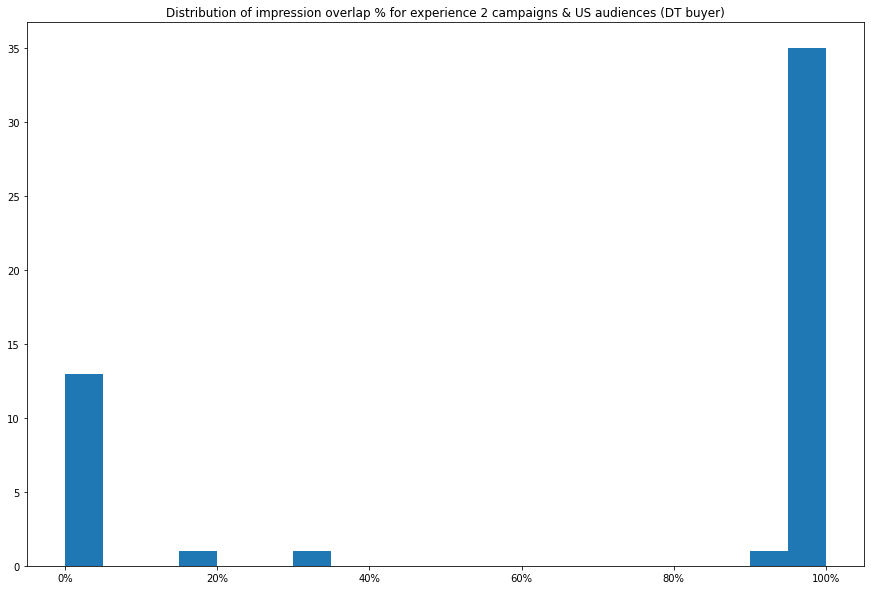

In [110]:
plt.figure(figsize = (15,10))
plt.hist(us_impressions.loc[(us_impressions.buyer == 'DT') & (us_impressions.campaign_type == 2), 'imp_overlap'], bins = 20)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.title('Distribution of impression overlap % for experience 2 campaigns & US audiences (DT buyer)')
# plt.xlim(.9,1)

In [6]:
top_campaign_q = bigquery_client.query(f"""
SELECT 
    r.ssb_campaign_uuid
    , c.name as campaign_name
    , sum(revenue)*256 as spend
FROM `apprec-prod.stats.rows` r
left join metadata.dt_campaigns c
    on r.ssb_campaign_uuid = c.uuid
WHERE date >= "{start_dt}" and date<="{end_dt}"
and left(r.id,2) = '00'
and r.ssb_buyer_id = 3549
group by 1,2
order by spend desc
""").to_dataframe()
top_campaign_q

ssb_campaign_uuid  \
0    c5534bbfcb4dccdd122f22da877a6f78   
1    60afc4f294695ffe7ea525534f019d20   
2    4c7f5d9964abdca5793b3d48f13fe6f9   
3    ebd6e39117bfd485b3b15243f3e07bad   
4    33bff90d655b976e9399f1d0b0463d22   
..                                ...   
163  eaeaa56f1dce5b0c407f9ba266ebe182   
164  f26adcfdd8b0a653e86528af46961c1d   
165  1a677bdff57ac529612052ffe2c29943   
166  8ab98b279f571f61349ab6138d0f51f6   
167  237771ab834d300727c842cadac8d617   

                                         campaign_name     spend  
0            Particle Media - News Break - US - VZW UA  173568.0  
1    Particle Media - News Break - US - VZW PR - Di...   87552.0  
2             Position Mobile – Weather Home – US – UA   63897.6  
3                         Android-Twitter-Twitter-US-2   55552.0  
4                   SmartNews_ATT_SingleTap_All_CPI_NA   39168.0  
..                                                 ...       ...  
163            Android-Opera Norway As-Opera News-FR-4       0.0  
164                   Position Mobile-WeatherHome-US-4       0.0  
165                   SingleTap-DSP-Word Jam-US-VZW-T1       0.0  
166               SingleTap_FB_ROW_Android_Video_FB_IN       0.0  
167              Android-King-Candy Crush-BR-3-Display       0.0  

[168 rows x 3 columns]

In [27]:
def classify_campaigns(r):
    if any(substr in str(r['campaign_name']).lower() for substr in exp_1):
        return 1
    elif any(substr in str(r['campaign_name']).lower() for substr in exp_4):
        return 4
    elif any(substr in str(r['campaign_name']).lower() for substr in exp_3):
        return 3
    elif any(substr in str(r['campaign_name']).lower() for substr in exp_2):
        return 2
    else:
        return np.nan
    
top_campaign_q['campaign_type'] = top_campaign_q.apply(lambda x:classify_campaigns(x), axis = 1)
top_campaign_ix = [0,10,18,23,24]
top_campaigns = top_campaign_q.iloc[top_campaign_ix, 0].to_list()
top_campaigns = tuple(top_campaigns)
top_campaign_q.iloc[top_campaign_ix]

ssb_campaign_uuid  \
0   c5534bbfcb4dccdd122f22da877a6f78   
10  5d294c23d51b0c64a63275f4b8412067   
18  32306faf44c94f31443228da180c50c7   
23  2da0b609215635e899c59e7a302a2f28   
24  460c77fda3ba6cdf651311f5eedb7187   

                                     campaign_name     spend  campaign_type  
0        Particle Media - News Break - US - VZW UA  173568.0            2.0  
10       Particle Media - News Break - US - ATT UA   24768.0            2.0  
18  DT-SingleTap-DSP-PlaySimple-WordTrip-US-UA-VZW   12185.6            2.0  
23           Opera News - Opera News - US - UA ATT    8640.0            2.0  
24        Android-SmartNews Inc-SmartNews-US-ATT-2    8448.0            2.0

In [40]:
top_impressions = bigquery_client.query(f"""
SELECT 
    r.ssb_campaign_uuid
    , c.name as campaign_name
    , aud.carrier
    , case when r.ssb_buyer_id = 3549 then 'DT' else 'other' end as buyer
    , sum(revenue) as spend
    , count(case when event_type = 'clear' then r.tid else NULL end) as impressions
    , count(case when event_type = 'clear' then aud.tid else NULL end) as audience_impressions
    , count(distinct case when event_type = 'clear' then r.tid else NULL end) as users
    , count(distinct case when event_type = 'clear' then aud.tid else NULL end) as audience_users
FROM `apprec-prod.stats.rows` r
left join (
    select 
        tid
        , carrier
    from `apprec-prod.audiences.dt_aud` 
    where country = 'US' 
    group by 1,2
) aud
    on r.tid = aud.tid
left join metadata.dt_campaigns c
    on r.ssb_campaign_uuid = c.uuid
WHERE date >= "{start_dt}" and date<="{end_dt}"
and r.ssb_buyer_id = 3549
and r.ssb_campaign_uuid in {top_campaigns}
group by 1,2,3,4
order by 1, users desc
""").to_dataframe()
top_impressions

ssb_campaign_uuid  \
0   2da0b609215635e899c59e7a302a2f28   
1   2da0b609215635e899c59e7a302a2f28   
2   2da0b609215635e899c59e7a302a2f28   
3   2da0b609215635e899c59e7a302a2f28   
4   2da0b609215635e899c59e7a302a2f28   
5   2da0b609215635e899c59e7a302a2f28   
6   32306faf44c94f31443228da180c50c7   
7   32306faf44c94f31443228da180c50c7   
8   32306faf44c94f31443228da180c50c7   
9   32306faf44c94f31443228da180c50c7   
10  32306faf44c94f31443228da180c50c7   
11  32306faf44c94f31443228da180c50c7   
12  460c77fda3ba6cdf651311f5eedb7187   
13  460c77fda3ba6cdf651311f5eedb7187   
14  460c77fda3ba6cdf651311f5eedb7187   
15  460c77fda3ba6cdf651311f5eedb7187   
16  460c77fda3ba6cdf651311f5eedb7187   
17  460c77fda3ba6cdf651311f5eedb7187   
18  5d294c23d51b0c64a63275f4b8412067   
19  5d294c23d51b0c64a63275f4b8412067   
20  5d294c23d51b0c64a63275f4b8412067   
21  5d294c23d51b0c64a63275f4b8412067   
22  5d294c23d51b0c64a63275f4b8412067   
23  5d294c23d51b0c64a63275f4b8412067   
24  5d294c23d51b0c64a63275f4b8412067   
25  c5534bbfcb4dccdd122f22da877a6f78   
26  c5534bbfcb4dccdd122f22da877a6f78   
27  c5534bbfcb4dccdd122f22da877a6f78   
28  c5534bbfcb4dccdd122f22da877a6f78   
29  c5534bbfcb4dccdd122f22da877a6f78   
30  c5534bbfcb4dccdd122f22da877a6f78   
31  c5534bbfcb4dccdd122f22da877a6f78   
32  c5534bbfcb4dccdd122f22da877a6f78   

                                     campaign_name     carrier buyer  \
0            Opera News - Opera News - US - UA ATT         att    DT   
1            Opera News - Opera News - US - UA ATT     verizon    DT   
2            Opera News - Opera News - US - UA ATT        None    DT   
3            Opera News - Opera News - US - UA ATT     cricket    DT   
4            Opera News - Opera News - US - UA ATT  uscellular    DT   
5            Opera News - Opera News - US - UA ATT    tracfone    DT   
6   DT-SingleTap-DSP-PlaySimple-WordTrip-US-UA-VZW     verizon    DT   
7   DT-SingleTap-DSP-PlaySimple-WordTrip-US-UA-VZW        None    DT   
8   DT-SingleTap-DSP-PlaySimple-WordTrip-US-UA-VZW         att    DT   
9   DT-SingleTap-DSP-PlaySimple-WordTrip-US-UA-VZW  uscellular    DT   
10  DT-SingleTap-DSP-PlaySimple-WordTrip-US-UA-VZW     cricket    DT   
11  DT-SingleTap-DSP-PlaySimple-WordTrip-US-UA-VZW    tracfone    DT   
12        Android-SmartNews Inc-SmartNews-US-ATT-2         att    DT   
13        Android-SmartNews Inc-SmartNews-US-ATT-2     verizon    DT   
14        Android-SmartNews Inc-SmartNews-US-ATT-2        None    DT   
15        Android-SmartNews Inc-SmartNews-US-ATT-2     cricket    DT   
16        Android-SmartNews Inc-SmartNews-US-ATT-2  uscellular    DT   
17        Android-SmartNews Inc-SmartNews-US-ATT-2    tracfone    DT   
18       Particle Media - News Break - US - ATT UA         att    DT   
19       Particle Media - News Break - US - ATT UA        None    DT   
20       Particle Media - News Break - US - ATT UA     verizon    DT   
21       Particle Media - News Break - US - ATT UA     cricket    DT   
22       Particle Media - News Break - US - ATT UA  uscellular    DT   
23       Particle Media - News Break - US - ATT UA    tracfone    DT   
24       Particle Media - News Break - US - ATT UA     samsung    DT   
25       Particle Media - News Break - US - VZW UA     verizon    DT   
26       Particle Media - News Break - US - VZW UA        None    DT   
27       Particle Media - News Break - US - VZW UA         att    DT   
28       Particle Media - News Break - US - VZW UA     cricket    DT   
29       Particle Media - News Break - US - VZW UA  uscellular    DT   
30       Particle Media - News Break - US - VZW UA    tracfone    DT   
31       Particle Media - News Break - US - VZW UA     samsung    DT   
32       Particle Media - News Break - US - VZW UA      sliide    DT   

        spend  impressions  audience_impressions    users  audience_users  
0     7137.00      1276377               1276377   434922          434922  
1       42.75         7104                  7104     2342

In [49]:
top_impressions.columns = top_impressions.columns[:2].to_list() + ['new_aud_carrier'] + top_impressions.columns[3:].to_list()
top_impressions['total_impressions'] = top_impressions.groupby('campaign_name')['impressions'].transform('sum')
top_impressions['total_users'] = top_impressions.groupby('campaign_name')['users'].transform('sum')
top_impressions['imp_overlap'] = top_impressions['audience_impressions']/top_impressions['total_impressions']
top_impressions['user_overlap'] = top_impressions['audience_users']/top_impressions['total_users']
top_impressions.to_csv(f'~/Downloads/top_campaign_audience_overlap_{start_dt}_{end_dt}.csv', index = False)
top_impressions

ssb_campaign_uuid  \
0   2da0b609215635e899c59e7a302a2f28   
1   2da0b609215635e899c59e7a302a2f28   
2   2da0b609215635e899c59e7a302a2f28   
3   2da0b609215635e899c59e7a302a2f28   
4   2da0b609215635e899c59e7a302a2f28   
5   2da0b609215635e899c59e7a302a2f28   
6   32306faf44c94f31443228da180c50c7   
7   32306faf44c94f31443228da180c50c7   
8   32306faf44c94f31443228da180c50c7   
9   32306faf44c94f31443228da180c50c7   
10  32306faf44c94f31443228da180c50c7   
11  32306faf44c94f31443228da180c50c7   
12  460c77fda3ba6cdf651311f5eedb7187   
13  460c77fda3ba6cdf651311f5eedb7187   
14  460c77fda3ba6cdf651311f5eedb7187   
15  460c77fda3ba6cdf651311f5eedb7187   
16  460c77fda3ba6cdf651311f5eedb7187   
17  460c77fda3ba6cdf651311f5eedb7187   
18  5d294c23d51b0c64a63275f4b8412067   
19  5d294c23d51b0c64a63275f4b8412067   
20  5d294c23d51b0c64a63275f4b8412067   
21  5d294c23d51b0c64a63275f4b8412067   
22  5d294c23d51b0c64a63275f4b8412067   
23  5d294c23d51b0c64a63275f4b8412067   
24  5d294c23d51b0c64a63275f4b8412067   
25  c5534bbfcb4dccdd122f22da877a6f78   
26  c5534bbfcb4dccdd122f22da877a6f78   
27  c5534bbfcb4dccdd122f22da877a6f78   
28  c5534bbfcb4dccdd122f22da877a6f78   
29  c5534bbfcb4dccdd122f22da877a6f78   
30  c5534bbfcb4dccdd122f22da877a6f78   
31  c5534bbfcb4dccdd122f22da877a6f78   
32  c5534bbfcb4dccdd122f22da877a6f78   

                                     campaign_name new_aud_carrier buyer  \
0            Opera News - Opera News - US - UA ATT             att    DT   
1            Opera News - Opera News - US - UA ATT         verizon    DT   
2            Opera News - Opera News - US - UA ATT            None    DT   
3            Opera News - Opera News - US - UA ATT         cricket    DT   
4            Opera News - Opera News - US - UA ATT      uscellular    DT   
5            Opera News - Opera News - US - UA ATT        tracfone    DT   
6   DT-SingleTap-DSP-PlaySimple-WordTrip-US-UA-VZW         verizon    DT   
7   DT-SingleTap-DSP-PlaySimple-WordTrip-US-UA-VZW            None    DT   
8   DT-SingleTap-DSP-PlaySimple-WordTrip-US-UA-VZW             att    DT   
9   DT-SingleTap-DSP-PlaySimple-WordTrip-US-UA-VZW      uscellular    DT   
10  DT-SingleTap-DSP-PlaySimple-WordTrip-US-UA-VZW         cricket    DT   
11  DT-SingleTap-DSP-PlaySimple-WordTrip-US-UA-VZW        tracfone    DT   
12        Android-SmartNews Inc-SmartNews-US-ATT-2             att    DT   
13        Android-SmartNews Inc-SmartNews-US-ATT-2         verizon    DT   
14        Android-SmartNews Inc-SmartNews-US-ATT-2            None    DT   
15        Android-SmartNews Inc-SmartNews-US-ATT-2         cricket    DT   
16        Android-SmartNews Inc-SmartNews-US-ATT-2      uscellular    DT   
17        Android-SmartNews Inc-SmartNews-US-ATT-2        tracfone    DT   
18       Particle Media - News Break - US - ATT UA             att    DT   
19       Particle Media - News Break - US - ATT UA            None    DT   
20       Particle Media - News Break - US - ATT UA         verizon    DT   
21       Particle Media - News Break - US - ATT UA         cricket    DT   
22       Particle Media - News Break - US - ATT UA      uscellular    DT   
23       Particle Media - News Break - US - ATT UA        tracfone    DT   
24       Particle Media - News Break - US - ATT UA         samsung    DT   
25       Particle Media - News Break - US - VZW UA         verizon    DT   
26       Particle Media - News Break - US - VZW UA            None    DT   
27       Particle Media - News Break - US - VZW UA             att    DT   
28       Particle Media - News Break - US - VZW UA         cricket    DT   
29       Particle Media - News Break - US - VZW UA      uscellular    DT   
30       Particle Media - News Break - US - VZW UA        tracfone    DT   
31       Particle Media - News Break - US - VZW UA         samsung    DT   
32       Particle Media - News Break - US - VZW UA          sliide    DT   

        spend  impressions  audience_impressions    users  audience_users